In [16]:
import os
from dotenv import load_dotenv, find_dotenv

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)  # This loads the variables from .env

True

In [ ]:
# This will be a tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

# This will be a tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=1.0)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools)

In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

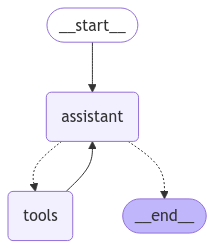

In [21]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)
memory = MemorySaver()

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
# specify a thread
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="Add 1 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages}, config)

In [23]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 1 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (851d719b-51f6-4a2a-823c-4ac4fcfc8790)
 Call ID: 851d719b-51f6-4a2a-823c-4ac4fcfc8790
  Args:
    a: 1.0
    b: 4.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  multiply (635ee4f5-2ce5-4509-afec-0e84e2ce2ae5)
 Call ID: 635ee4f5-2ce5-4509-afec-0e84e2ce2ae5
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  divide (e5f489e0-420a-42d7-96a3-58ec12bed7b1)
 Call ID: e5f489e0-420a-42d7-96a3-58ec12bed7b1
  Args:
    a: 10.0
    b: 5.0
========

In [24]:
messages = [HumanMessage(content="Multiply previous result by 5")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 1 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (851d719b-51f6-4a2a-823c-4ac4fcfc8790)
 Call ID: 851d719b-51f6-4a2a-823c-4ac4fcfc8790
  Args:
    a: 1.0
    b: 4.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  multiply (635ee4f5-2ce5-4509-afec-0e84e2ce2ae5)
 Call ID: 635ee4f5-2ce5-4509-afec-0e84e2ce2ae5
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  divide (e5f489e0-420a-42d7-96a3-58ec12bed7b1)
 Call ID: e5f489e0-420a-42d7-96a3-58ec12bed7b1
  Args:
    a: 10.0
    b: 5.0
========

In [25]:
messages

{'messages': [HumanMessage(content='Add 1 and 4. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='d17c5127-b967-4cdf-bd0d-cd26867a1e5d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 1.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-826adb04-6cab-49f2-9871-0bd0e281eabb-0', tool_calls=[{'name': 'add', 'args': {'a': 1.0, 'b': 4.0}, 'id': '851d719b-51f6-4a2a-823c-4ac4fcfc8790', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 3, 'total_tokens': 80, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='5', name='add', id='d23189f6-9a32-4023-890f-20185d8beaab', tool_call_id='851d719b-51f6-4a2a-823c-4ac4fcfc8790'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 5.0, "b": 2.0}'}}, response_metadat